In [1]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from qiskit.providers.fake_provider import FakeAthens

from hamiltonian_learning import Hamiltonian_Learning
from preparation import rabi_xy, rabi_z, discrete_cmap

In [2]:
SMALL_SIZE = 8
plt.rcParams['figure.figsize'] = [3, 2]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slowe
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)

In [3]:
lam_labels = np.array(["mu0", "A0", "B0", "mu1", "A1", "B1"])
t_max = 10*1e-7
dt = 2.2222222222222221e-10
N_t = 100
sig = 30
ts = (np.linspace(4*sig*dt, t_max, int(N_t))/dt).astype(int)
ts = ts[1:]
Us = [0, 1]
Ms = [0, 1, 2]
f_rabi = [rabi_xy, rabi_xy, rabi_z, rabi_xy, rabi_xy, rabi_z]
path = "C:\\Arbeit\\FakeAthenSimulation\\experiment_data\\echo\\c1t0_03amp_30sig_rr01_echo\\"

In [4]:
algorithm = Hamiltonian_Learning(backend=FakeAthens(), ts= ts, Us=Us, Ms=Ms, n_batch=40, f_rabi=f_rabi)
n_iter = 0
algorithm.set_n_iter(n_iter)
loss_hist = []

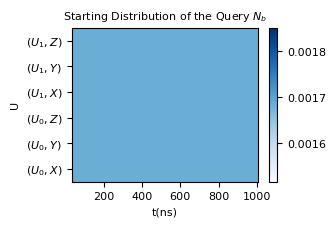

In [5]:
algorithm.sample_query()
p_q = algorithm.get_p_q()

U_label= [r"$(U_0, X)$",r"$(U_0, Y)$",r"$(U_0, Z)$",r"$(U_1, X)$",r"$(U_1, Y)$",r"$(U_1, Z)$"]
fake_UM = np.arange(6)

plt.figure()
plt.pcolormesh(ts*dt*1e9, fake_UM, p_q, cmap="Blues")
plt.colorbar()
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t(ns)')
plt.title(r'Starting Distribution of the Query $N_b$')
plt.show()

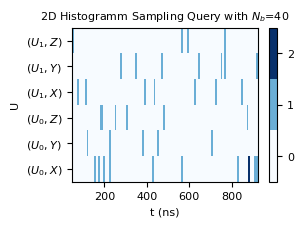

In [6]:
data = algorithm.get_data()
batch_size = algorithm.n_batch
UM_complex = algorithm.UM_labels
N_UM = len(UM_complex)

UMidx = algorithm.get_n_data_list()
H, xedges, yedges = np.histogram2d(data["t"]*dt*1e9, UMidx, bins=[N_t, N_UM])
H = H.T

binwidth = (N_UM-1)/N_UM/2
fake_UM = np.linspace(1, N_UM*2-1, N_UM)*binwidth

plt.figure()
colormesh = plt.pcolormesh(xedges, yedges, H, cmap=discrete_cmap(int(np.max(H)+1), "Blues"))
plt.colorbar(colormesh, ticks=range(int(np.max(H)+1)))
plt.clim(-0.5, int(np.max(H)+1) - 0.5)
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t (ns)')
plt.title(r'2D Histogramm Sampling Query with $N_b$={}'.format(batch_size))
plt.show()

In [7]:
data0 = algorithm.get_data()

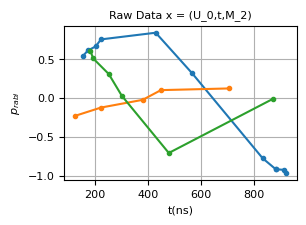

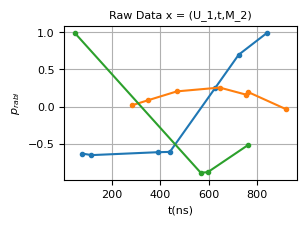

In [8]:
algorithm.run_fake_sim(path =path)
exp_list = algorithm.get_reformed_data()
for i in range(len(exp_list)):
    if i%3 == 0:
        plt.figure()
    plt.plot(exp_list[i]["t"]*dt*1e9, exp_list[i]["count"], ".-")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0:.0f},t,M_{1:.0f})'.format(UM_complex[i].real, UM_complex[i].imag))
    plt.grid()

In [9]:
testdf = algorithm.get_data()
testdf

,t,U,M,UM,count,weight,n_iter,mu0,A0,B0,C0,mu1,A1,B1,C1
0,3969,0,0,0.0+0.0j,-0.917969,1,0,0,0,0,0,0,0,0,0
1,3969,0,0,0.0+0.0j,-0.917969,1,0,0,0,0,0,0,0,0,0
2,3172,0,1,0.0+1.0j,0.121094,1,0,0,0,0,0,0,0,0,0
3,2818,1,0,1.0+0.0j,0.244141,1,0,0,0,0,0,0,0,0,0
4,1756,1,0,1.0+0.0j,-0.613281,1,0,0,0,0,0,0,0,0,0
5,2907,1,1,1.0+1.0j,0.253906,1,0,0,0,0,0,0,0,0,0
6,783,0,0,0.0+0.0j,0.609375,1,0,0,0,0,0,0,0,0,0
7,1004,0,1,0.0+1.0j,-0.125000,1,0,0,0,0,0,0,0,0,0
8,4146,1,1,1.0+1.0j,-0.037109,1,0,0,0,0,0,0,0,0,0
9,3438,1,2,1.0+2.0j,-0.515625,1,0,0,0,0,0,0,0,0,0


No estimation for nr. 1 due to the lackness of data
No estimation for nr. 5 due to the lackness of data
update loss


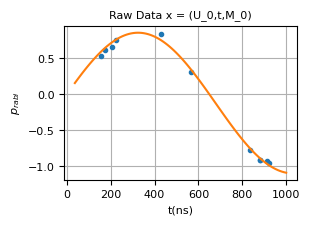

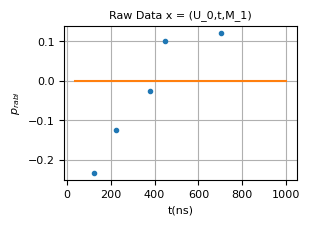

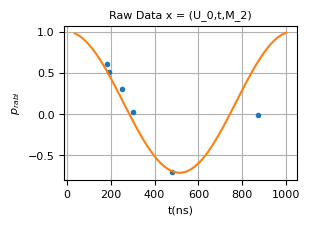

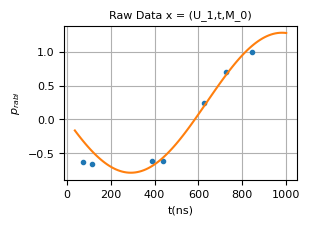

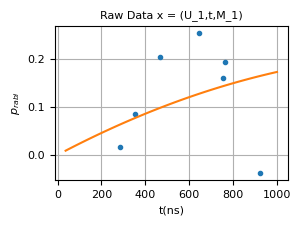

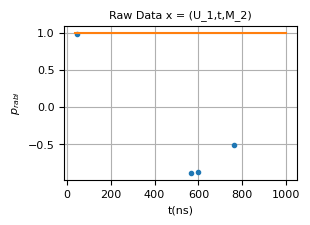

In [10]:
# params = np.array(algorithm.fit_params(method="L-BFGS-B"))
params = np.array(algorithm.fit_params(method="COBYLA"))

for i in range(len(exp_list)):
    n_rabi = i%3
    t = exp_list[i]["t"]*dt
    p = exp_list[i]["count"]
    if i//3 == 0:
        lam = params[i,:4]
    if i//3 == 1:
        lam = params[i,4:]
    p_pred = f_rabi[n_rabi](ts*dt, *lam)
    # if n_rabi == 0:
    plt.figure()
    plt.plot(t*1e9, p , ".")
    plt.plot(ts*dt*1e9, p_pred , "-")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0:.0f},t,M_{1:.0f})'.format(UM_complex[i].real, UM_complex[i].imag))
    plt.grid()

In [11]:
loss = algorithm.loss
loss_hist.append(loss)

algorithm.optimize_query(lr=10)
p_q = algorithm.p_q

U_label= [r"$(U_0, X)$",r"$(U_0, Y)$",r"$(U_0, Z)$",r"$(U_1, X)$",r"$(U_1, Y)$",r"$(U_1, Z)$"]
fake_UM = np.arange(6)

plt.figure()
plt.pcolormesh(ts*dt*1e9, fake_UM, p_q, cmap="Blues")
plt.colorbar()
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t(ns)')
plt.title(r'Starting Distribution of the Query $N_b$')
plt.show()

LinAlgError: Singular matrix

In [ ]:
# testdata = algorithm.get_data()
# dupdata = testdata.iloc[:5].copy()
# dupdata.loc[:,["count","weight"]] = 1
# dupdata = pd.concat([testdata, dupdata]).reset_index(drop=True)
# dupitems = dupdata.loc[dupdata[["t","UM"]].duplicated(keep=False)]
# dupitems

In [ ]:
# meanvalues = dupitems.groupby(["t","UM"])["count"].mean()
# # meanvalues["t"]
# for grouplabel, items in meanvalues.items():
# #     print(grouplabel[0])
#     dupitems.loc[(dupitems["t"]==grouplabel[0])&(dupitems["UM"]==grouplabel[1]), "count"] = items
# dupdata.loc[np.invert(dupdata[["t","UM"]].duplicated(keep=False))]

In [ ]:
n_iter = n_iter+1
algorithm.set_n_iter(n_iter)

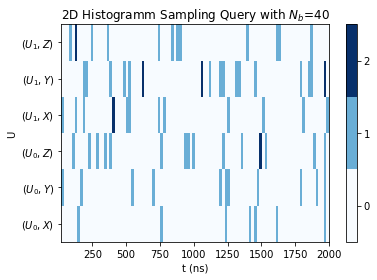

In [ ]:
algorithm.sample_query()
data = algorithm.get_data()

UMidx = algorithm.get_n_data_list()
H, xedges, yedges = np.histogram2d(data["t"]*dt*1e9, UMidx, bins=[N_t, N_UM])
H = H.T

binwidth = (N_UM-1)/N_UM/2
fake_UM = np.linspace(1, N_UM*2-1, N_UM)*binwidth

plt.figure()
colormesh = plt.pcolormesh(xedges, yedges, H, cmap=discrete_cmap(int(np.max(H)+1), "Blues"))
plt.colorbar(colormesh, ticks=range(int(np.max(H)+1)))
plt.clim(-0.5, int(np.max(H)+1) - 0.5)
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t (ns)')
plt.title(r'2D Histogramm Sampling Query with $N_b$={}'.format(batch_size))
plt.show()

In [ ]:
algorithm.get_data()

,t,U,M,UM,count,weight,n_iter,mu0,A0,B0,mu1,A1,B1
0,8545,0,2,0.0+2.0j,-0.978516,0.001555,0,4.712389e+06,0.574337,0.206881,0.000000e+00,0.000000,0.000000
1,8181,1,0,1.0+0.0j,-0.019531,0.211461,0,0.000000e+00,0.000000,0.000000,1.570799e+06,0.912676,0.000327
2,1636,1,2,1.0+2.0j,0.177734,0.001671,0,0.000000e+00,0.000000,0.000000,1.000000e+00,0.000000,0.000000
3,454,0,2,0.0+2.0j,0.685547,0.002264,0,4.712389e+06,0.574337,0.206881,0.000000e+00,0.000000,0.000000
4,2272,1,0,1.0+0.0j,0.996094,0.018149,0,0.000000e+00,0.000000,0.000000,1.570799e+06,0.912676,0.000327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,4727,1,1,1.0+1.0j,0.000000,1.000000,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
36,2454,0,1,0.0+1.0j,0.000000,1.000000,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
37,5636,0,1,0.0+1.0j,0.000000,1.000000,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000
38,545,1,2,1.0+2.0j,0.000000,1.000000,1,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [ ]:
UMidx, algorithm.get_n_data_list()

(array([2, 3, 5, 2, 3, 1, 4, 2, 5, 1, 4, 4, 0, 2, 4, 4, 4, 0, 5, 0, 0, 2,
        1, 3, 5, 3, 2, 4, 2, 3, 1, 4, 1, 4, 0, 2, 3, 3, 4, 2, 4, 2, 0, 5,
        5, 5, 2, 1, 3, 4, 1, 2, 5, 2, 4, 1, 2, 1, 4, 5, 3, 5, 4, 4, 4, 0,
        5, 3, 3, 5, 3, 4, 2, 4, 3, 4, 1, 1, 5, 2], dtype=int64),
 array([2, 3, 5, 2, 3, 1, 4, 2, 5, 1, 4, 4, 0, 2, 4, 4, 4, 0, 5, 0, 0, 2,
        1, 3, 5, 3, 2, 4, 2, 3, 1, 4, 1, 4, 0, 2, 3, 3, 4, 2, 4, 2, 0, 5,
        5, 5, 2, 1, 3, 4, 1, 2, 5, 2, 4, 1, 2, 1, 4, 5, 3, 5, 4, 4, 4, 0,
        5, 3, 3, 5, 3, 4, 2, 4, 3, 4, 1, 1, 5, 2], dtype=int64))

array([[5000, 1.0, 1.0],
       [4272, 0.0, 2.0],
       [6363, 0.0, 0.0],
       [7363, 1.0, 2.0],
       [545, 1.0, 2.0],
       [7272, 1.0, 2.0],
       [1272, 0.0, 2.0],
       [8090, 0.0, 1.0],
       [3363, 1.0, 0.0],
       [2181, 1.0, 1.0],
       [5545, 0.0, 1.0],
       [1000, 0.0, 2.0],
       [363, 1.0, 2.0],
       [4545, 0.0, 2.0],
       [8454, 1.0, 1.0],
       [5363, 0.0, 1.0],
       [1545, 0.0, 2.0],
       [90, 0.0, 1.0],
       [818, 1.0, 1.0],
       [3818, 1.0, 2.0],
       [6818, 1.0, 0.0],
       [8454, 1.0, 2.0],
       [8090, 1.0, 1.0],
       [8363, 1.0, 1.0],
       [6545, 1.0, 1.0],
       [8909, 0.0, 0.0],
       [4000, 1.0, 2.0],
       [545, 1.0, 0.0],
       [2363, 1.0, 0.0],
       [1090, 1.0, 2.0],
       [90, 1.0, 0.0],
       [1727, 1.0, 1.0],
       [1727, 0.0, 2.0],
       [8909, 1.0, 1.0],
       [3545, 1.0, 0.0],
       [4727, 1.0, 1.0],
       [2454, 0.0, 1.0],
       [5636, 0.0, 1.0],
       [545, 1.0, 2.0],
       [6727, 0.0, 2.0]], dtype=ob

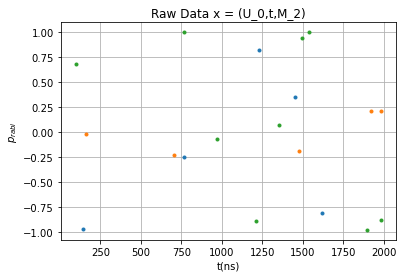

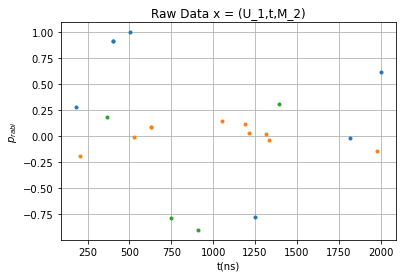

In [31]:
algorithm.run_fake_sim(path =path)
# exp_list = algorithm.get_reformed_data()
for i in range(len(exp_list)):
    if i%3 == 0:
        plt.figure()
    plt.plot(exp_list[i]["t"]*dt*1e9, exp_list[i]["count"], ".")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0:.0f},t,M_{1:.0f})'.format(UM_complex[i].real, UM_complex[i].imag))
    plt.grid()
algorithm.get_q_sample()

Fitting Rabi Set Nr. 0
Fitting Rabi Set Nr. 1
Fitting Rabi Set Nr. 2
Fitting Rabi Set Nr. 3
Fitting Rabi Set Nr. 4
Fitting Rabi Set Nr. 5


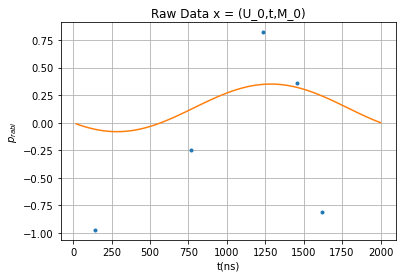

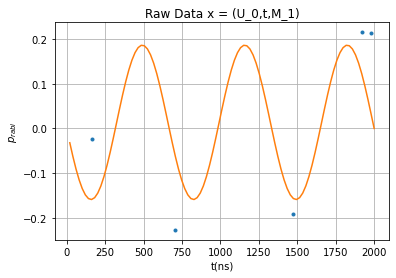

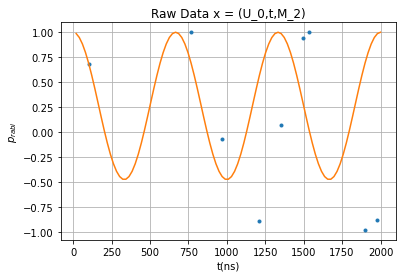

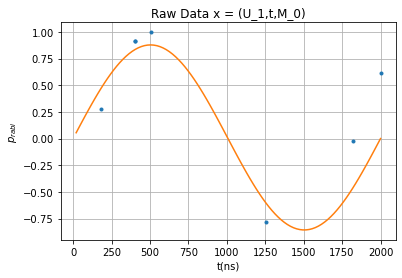

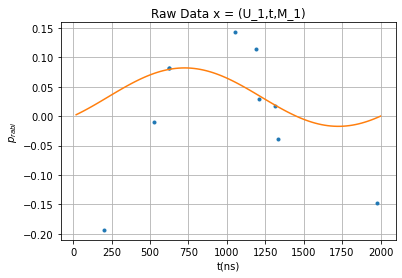

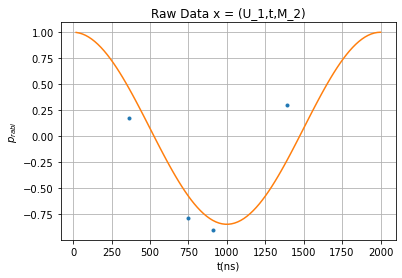

In [32]:
# params = np.array(algorithm.fit_params(method="L-BFGS-B"))
params = np.array(algorithm.fit_params(method="COBYLA"))

for i in range(len(exp_list)):
    n_rabi = i%3
    t = exp_list[i]["t"]*dt
    p = exp_list[i]["count"]
    if i//3 == 0:
        lam = params[i,:3]
    if i//3 == 1:
        lam = params[i,3:]
    p_pred = f_rabi[n_rabi](ts*dt, *lam)
    # if n_rabi == 0:
    plt.figure()
    plt.plot(t*1e9, p , ".")
    plt.plot(ts*dt*1e9, p_pred , "-")
    plt.xlabel("t(ns)")
    plt.ylabel(r"$p_{rabi}$")
    plt.title(r'Raw Data x = (U_{0:.0f},t,M_{1:.0f})'.format(UM_complex[i].real, UM_complex[i].imag))
    plt.grid()

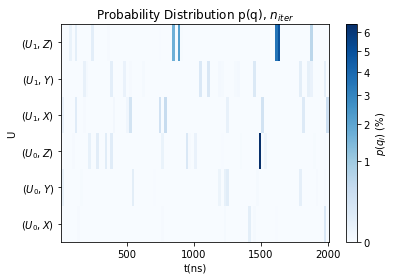

In [71]:
import matplotlib.colors as colors

loss = algorithm.loss
loss_hist.append(loss)

algorithm.optimize_query(lr=0.1)
p_q = algorithm.p_q

U_label= [r"$(U_0, X)$",r"$(U_0, Y)$",r"$(U_0, Z)$",r"$(U_1, X)$",r"$(U_1, Y)$",r"$(U_1, Z)$"]
fake_UM = np.arange(6)

plt.figure()
plt.pcolormesh(ts*dt*1e9, fake_UM, p_q*100, norm=colors.PowerNorm(gamma=0.5), cmap="Blues")
cbar = plt.colorbar()
cbar.set_label(r'$p(q_i)$ (%)')
plt.yticks(fake_UM, labels=U_label)
plt.ylabel('U')
plt.xlabel('t(ns)')
plt.title(r'Probability Distribution p(q), $n_{{iter}}$')
plt.show()

In [34]:
data0 = algorithm.get_data()
data1 = algorithm.get_data()
data_concat = pd.concat([data0, data1], ignore_index=True)
data_concat.groupby(["t","UM"]).mean()

U    M     count    weight  n_iter           mu0        A0  \
t    UM                                                                     
90   1j      0.0  1.0 -0.216797  0.003061     1.0  4.712389e+06 -0.171858   
     (1+0j)  1.0  0.0 -0.164062  0.001731     1.0  0.000000e+00  0.000000   
363  (1+2j)  1.0  2.0  0.927734  0.002861     1.0  0.000000e+00  0.000000   
454  2j      0.0  2.0  0.685547  0.002264     0.0  4.712389e+06  0.737253   
545  (1+0j)  1.0  0.0  0.148438  0.003000     1.0  0.000000e+00  0.000000   
...          ...  ...       ...       ...     ...           ...       ...   
8909 0j      0.0  0.0  0.695312  0.006825     1.0  1.570797e+06 -0.168922   
     1j      0.0  1.0  0.212891  0.002399     0.0  4.712389e+06 -0.171858   
     2j      0.0  2.0 -0.876953  0.000216     0.0  4.712389e+06  0.737253   
     (1+1j)  1.0  1.0 -0.148438  0.002830     0.5  0.000000e+00  0.000000   
9000 (1+0j)  1.0  0.0  0.611328  0.528037     0.0  0.000000e+00  0.000000   

                   B0           mu1        A1        B1  
t    UM                                                  
90   1j      0.027296  0.000000e+00  0.000000  0.000000  
     (1+0j)  0.000000  1.570798e+06  0.866852  0.020876  
363  (1+2j)  0.000000  1.570797e+06  0.924074  0.237566  
454  2j      0.026808  0.000000e+00  0.000000  0.000000  
545  (1+0j)  0.000000  1.570798e+06  0.866852  0.020876  
...               ...           ...       ...       ...  
8909 0j      0.268854  0.000000e+00  0.000000  0.000000  
     1j      0.027296  0.000000e+00  0.000000  0.000000  
     2j      0.026808  0.000000e+00  0.000000  0.000000  
     (1+1j)  0.000000  1.570796e+06  0.037697  0.064619  
9000 (1+0j)  0.000000  1.570798e+06  0.866852  0.020876  

[74 rows x 11 columns]

In [35]:
3//3

1